In [6]:
import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.models.plr_ash import PenalizedMrASH
from mrashpen.models.normal_means_ash import NormalMeansASH

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 0.1):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    prior_grid = (np.arange(k) * 5) + 0.1
    prior_grid *= scale
    return w, prior_grid

In [7]:
def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, res):
    bhat = res.coef
    ypred = np.dot(Xtest, bhat)
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    plt.tight_layout()
    plt.show()

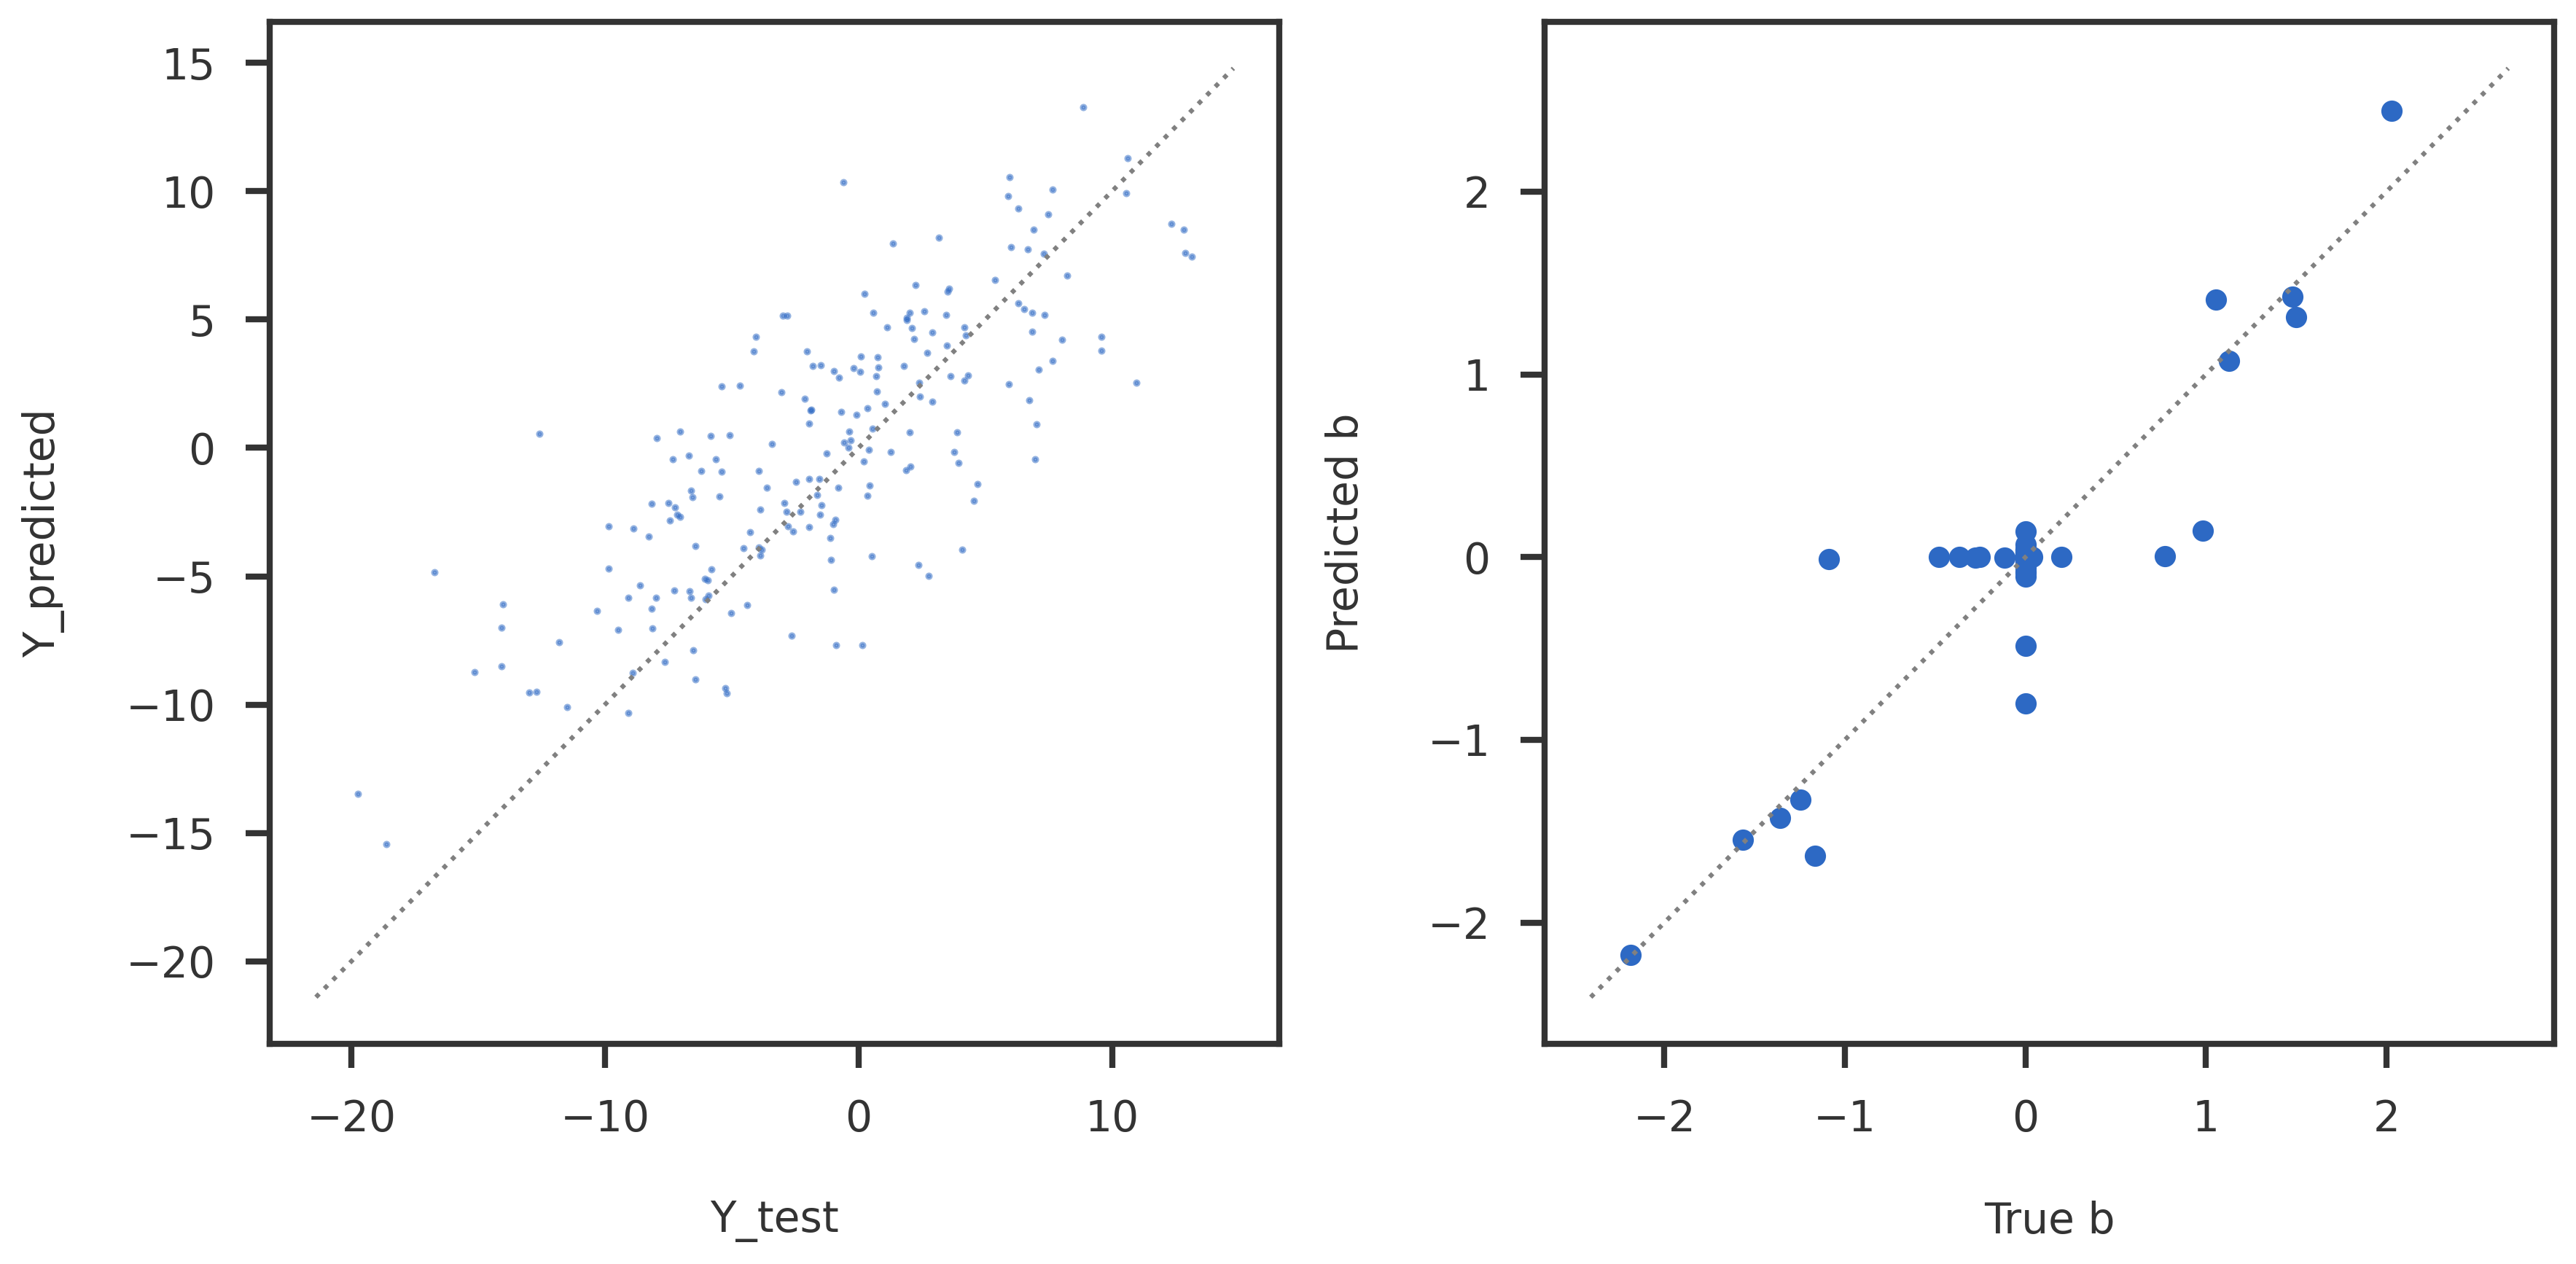

In [8]:
n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, 
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = strue * strue)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs)

In [83]:
def elbo_second_term(phijk, wk):
    p, k = phijk.shape
    tj = np.zeros(p)
    for j in range(p):
        tk = np.zeros(k)
        for i in range(k):
            if phijk[j, i] != 0:
                tk[i] = phijk[j, i] * np.log(phijk[j, i] / wk[i])
        tj[j] = np.sum(tk)
    return - np.sum(tj)

def mrash_elbo_direct(X, y, b, s2, wk, sk, dj = None):
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    '''
    Precalculate
    '''
    n, p   = X.shape
    bbar   = b.copy()
    rbar   = y - np.dot(X, bbar)
    btilde = bbar + np.dot(X.T, rbar) / dj
    sk2 = np.square(sk)
    '''
    NM posterior phijk, mujk, vjk
    '''
    phijk = np.zeros((p, k))
    mujk  = np.zeros((p, k))
    vjk2  = np.zeros((p, k))
    for j in range(p):
        z = np.array([btilde[j]])
        nmash = NormalMeansASH(z, np.sqrt(s2 / dj[j]), wk, sk, debug = False)
        phik, muk, vk2 = nmash.posterior()
        phijk[j, :] = phik
        mujk[j, :] = muk
        vjk2[j, :] = vk2
    mujk2 = np.square(mujk)
    '''
    The terms in ELBO
    '''
    t1     = - 0.5 * n * np.log(2 * np.pi * s2)
    t2     = - 0.5 * np.dot(rbar.T, rbar) / s2
    t3     = - 0.5 * np.sum(dj * (np.sum(phijk * (mujk * mujk + vjk2), axis = 1) - (bbar * bbar))) / s2
    #t4     = - np.sum(phijk[:, 1:] * np.log(phijk[:, 1:] / wk[1:]))
    t4     = elbo_second_term(phijk, wk)
    t5     = 0.5 * np.sum(phijk[:, 1:] * \
                          (1 + np.log(vjk2[:, 1:] / sk2[1:]) - (mujk2[:, 1:] + vjk2[:, 1:]) / sk2[1:]))
    elbo   = t1 + t2 + t3 + t4 + t5
    return elbo #, t1, t2, t3, t4, t5


def iterative_update_sigma2(X, y, b, wk, sk, dj, s2old, eps = 1e-8, max_iter = 100):
    '''
    Precalculate
    '''
    n, p = X.shape
    rbar = y - np.dot(X, b)
    btilde = b + np.dot(X.T, rbar) / dj
    t1 = np.dot(rbar.T, rbar)
    t2 = np.sum(dj * (btilde - b) * b)
    t3part = p * (1 - wk[0])
    denom = n + p * (1 - wk[0])
    '''
    Iteratively update sigma^2
    '''
    itr_s2 = s2old
    obj = mrash_elbo_direct(X, y, b, itr_s2, wk, sk, dj = dj)
    #pmash = PenalizedMrASH(X, y, b, np.sqrt(itr_s2), wk, sk, dj = dj, debug = False)
    #obj = pmash.objective
    obj_path = list()
    obj_path.append(obj)
    for itr in range(1, max_iter):
        print (f"Sigma2 update. Iteration {itr}, sigma2 = {itr_s2:.4f}, objective = {obj:.4f}")
        itr_s2_old = itr_s2
        obj_old = obj
        '''
        Inner update
        '''
        itr_s2 = (t1 + t2 + t3part * itr_s2) / denom
        '''
        New objective
        '''
        obj = mrash_elbo_direct(X, y, b, itr_s2, wk, sk, dj = dj)
        #pmash  = PenalizedMrASH(X, y, b, np.sqrt(itr_s2), wk, sk, dj = dj, debug = False)
        #obj = pmash.objective
        obj_path.append(obj)
        if obj < obj_old:
            print(f"*** WARNING: In sigma2 udate. Wrong direction. {obj:.4f} {obj_old:.4f}")
        if obj - obj_old < eps:
            break
    return itr_s2, obj_path, itr


def mrash_plobj_direct(X, y, b, s2, wk, sk, dj = dj):
    pmash  = PenalizedMrASH(X, y, b, np.sqrt(s2), wk, sk, dj = dj, debug = False)
    return pmash.objective


def mrash_objective(X, y, b, s2, wk, sk, dj = dj, method = 'ELBO'):
    if method == 'ELBO':
        obj = - mrash_elbo_direct(X, y, b, s2, wk, sk, dj = dj)
    elif method == 'penalized_objective':
        obj = mrash_plobj_direct(X, y, b, s2, wk, sk, dj = dj)
    return obj
    


def update_sigma2(X, y, b, wk, dj, s2old):
    n, p = X.shape
    rbar = y - np.dot(X, b)
    btilde = b + np.dot(X.T, rbar) / dj
    t1 = np.dot(rbar.T, rbar)
    t2 = np.sum(dj * (btilde - b) * b)
    t3 = p * (1 - wk[0]) * s2old
    s2new = (t1 + t2 + t3) / (n + p * (1 - wk[0]))
    return s2new


def plr_fit(X, y, sk, binit = None, winit = None, s2init = strue * strue, 
            max_iter = 10, eps = 1e-4, convergence_method = 'penalized_objective'):
    '''
    Initializations
    '''
    n, p = X.shape
    k = sk.shape[0]
    if binit is None: binit = np.zeros(p)
    if winit is None: winit, _ = initialize_ash_prior(k)
    obj_path = list()
    dj = np.sum(np.square(X), axis = 0)
    '''
    Updates
    Iteration 0
    '''
    bbar = binit
    s2   = s2init
    prior = winit
    obj = mrash_objective(X, y, bbar, s2, prior, sk, dj = dj, method = convergence_method)
    obj_path.append(obj)
    '''
    Iterations
    '''
    for itr in range(1, max_iter):
        obj_old   = obj
        bbar_old  = bbar
        prior_old = prior
        s2_old    = s2
        '''
        Update sigma^2
        '''
        #s2, _, _ = iterative_update_sigma2(X, y, bbar, prior, sk, dj, s2_old, eps = 1e-8, max_iter = 100)
        #s2 = update_sigma2(X, y, bbar, prior, dj, s2_old)
        '''
        Update b and w
        '''
        plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, 
                debug = False, display_progress = False, maxiter = 1000, tol = 1e-8)
        plr_lbfgs.fit(X, y, sk, binit = bbar, winit = prior, s2init = s2)
        bbar  = plr_lbfgs.coef
        prior = plr_lbfgs.prior
        '''
        Update sigma^2
        '''
        #s2, _, _ = iterative_update_sigma2(X, y, bbar, prior, sk, dj, s2_old, eps = 1e-8, max_iter = 100)
        s2 = update_sigma2(X, y, bbar, prior, dj, s2_old)
        '''
        Convergence
        '''
        obj = mrash_objective(X, y, bbar, s2, prior, sk, dj = dj, method = convergence_method)
        obj_path.append(obj)
        print(f"Iteration {itr}, sigma2 = {s2:.4f}, Objective = {obj:.4f}")
        if obj > obj_old:
            print(f"Wrong Objective direction | {obj:.4f} is higher than {obj_old:.4f}")
        if obj_old - obj < eps:
            break
    return bbar, prior, s2, obj_path

In [84]:
bopt, wkopt, s2opt, elbo_path = plr_fit(X, y, sk, winit = wk, s2init = 2)

Iteration 1, sigma2 = 2.2488, Objective = -4619.1621
Iteration 2, sigma2 = 2.2509, Objective = -4621.5303
Iteration 3, sigma2 = 2.4894, Objective = -4626.8169
Iteration 4, sigma2 = 2.4588, Objective = -4621.3559
Wrong Objective direction | -4621.3559 is higher than -4626.8169


In [56]:
strue * strue

12.344883118460732

In [57]:
s2opt

11.748439512648112

In [39]:
binit = np.zeros(p)
winit = wk
s2init = 5.0
elbo_path = list()
dj = np.sum(np.square(X), axis = 0)

In [40]:
'''
Updates
Iteration 0
'''
bbar = binit
s2   = s2init
prior = winit
elbo = mrash_elbo_direct(X, y, bbar, s2, prior, sk, dj = dj)
elbo_path.append(elbo)

In [41]:
elbo

-16567.747313858687

In [42]:
itr = 1
elbo_old  = elbo
bbar_old  = bbar
prior_old = prior
s2_old    = s2
'''
Update b and w
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, 
        debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = bbar, winit = prior, s2init = s2)
bbar  = plr_lbfgs.coef
prior = plr_lbfgs.prior

In [43]:
mrash_elbo_direct(X, y, bbar, s2_old, prior, sk, dj = dj)

-638.6428123395095

In [44]:
s2, _, _ = iterative_update_sigma2(X, y, bbar, prior, sk, dj, s2_old, eps = 1e-8, max_iter = 100)

Sigma2 update. Iteration 1, sigma2 = 5.0000, objective = -638.6428
*** WARNING: In sigma2 udate. Wrong direction. -616.7012 -638.6428


In [45]:
s2

(5.9979122137130085, [-638.6428123395095, -616.7012311324752], 1)

In [33]:
'''
Update sigma^2
'''
s2 = iterative_update_sigma2(X, y, bbar, prior, sk, dj, s2_old, eps = 1e-8, max_iter = 100)
'''
Convergence
'''
elbo = mrash_elbo_direct(X, y, bbar, s2, prior, sk, dj = dj)

/tmp/ipykernel_18625/1984007639.py:31: RuntimeWarning: invalid value encountered in true_divide
  t4     = - np.sum(phijk[:, 1:] * np.log(phijk[:, 1:] / wk[1:]))


Sigma2 update. Iteration 1, sigma2 = 5.0000, objective = nan
Sigma2 update. Iteration 2, sigma2 = 5.9979, objective = nan
Sigma2 update. Iteration 3, sigma2 = 6.1417, objective = nan
Sigma2 update. Iteration 4, sigma2 = 6.1625, objective = nan
Sigma2 update. Iteration 5, sigma2 = 6.1654, objective = nan
Sigma2 update. Iteration 6, sigma2 = 6.1659, objective = nan
Sigma2 update. Iteration 7, sigma2 = 6.1659, objective = nan
Sigma2 update. Iteration 8, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 9, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 10, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 11, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 12, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 13, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 14, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 15, sigma2 = 6.1660, objective = nan
Sigma2 update. Iteration 16, sigma2 = 6.1660, objective = nan
Sigma2 update. It

/tmp/ipykernel_18625/1984007639.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nmash = NormalMeansASH(z, np.sqrt(s2 / dj[j]), wk, sk, debug = False)


TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [28]:
    '''
    Iterations
    '''
    for itr in range(1, max_iter):
        elbo_old  = elbo
        bbar_old  = bbar
        prior_old = prior
        s2_old    = s2
        '''
        Update b and w
        '''
        plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, 
                debug = False, display_progress = False)
        plr_lbfgs.fit(X, y, sk, binit = bbar, winit = prior, s2init = s2)
        bbar  = plr_lbfgs.coef
        prior = plr_lbfgs.prior
        '''
        Update sigma^2
        '''
        s2 = iterative_update_sigma2(X, y, bbar, prior, sk, dj, s2_old, eps = 1e-8, max_iter = 100)
        '''
        Convergence
        '''
        elbo = mrash_elbo_direct(X, y, bbar, s2, prior, sk, dj = dj)
        elbo_path.append(elbo)
        if elbo < elbo_old:
            print(f"Wrong ELBO direction | {elbo:.4f} is less than {elbo_old:.4f}")
        if elbo - elbo_old < eps:
            break

-16567.747313858687